# Coronagraph propagation

In this notebook, we do a propagation through a coronagaph, once by itself, and then through the entire optical setup of the THD2 testbed.

In [1]:
import os
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
from Asterix import Asterix_root
from Asterix.utils import read_parameter_file
from Asterix.optics import Pupil, Coronagraph, DeformableMirror, Testbed

In [2]:
# Read configuration file
your_directory = Asterix_root
your_parameter_file_name = 'Example_param_file.ini'

CORONAGRAPH = 'wrapped_vortex'

parameter_file_path = os.path.join(your_directory, your_parameter_file_name)

# Need different setup for apodizer plane between coronagrpah alone and coronagraph inside of testbed
config_coro = read_parameter_file(parameter_file_path, NewCoronaconfig={'corona_type': CORONAGRAPH,
                                                                        'filename_instr_apod': 'RoundPup'})
config_thd = read_parameter_file(parameter_file_path, NewCoronaconfig={'corona_type': CORONAGRAPH,
                                                                       'filename_instr_apod': 'Clear'})

In [3]:
Data_dir = config_thd["Data_dir"]
onbench = config_thd["onbench"]
modelconfig = config_thd["modelconfig"]
DMconfig = config_thd["DMconfig"]
Coronaconfig_coro = config_coro["Coronaconfig"]
Coronaconfig_thd = config_thd["Coronaconfig"]
Estimationconfig = config_thd["Estimationconfig"]
Correctionconfig = config_thd["Correctionconfig"]
Loopconfig = config_thd["Loopconfig"]
SIMUconfig = config_thd["SIMUconfig"]
Name_Experiment = SIMUconfig["Name_Experiment"]

In [4]:
model_local_dir = os.path.join(Data_dir, "Model_local")
matrix_dir = os.path.join(Data_dir, "Interaction_Matrices")
result_dir = os.path.join(Data_dir, "Results", Name_Experiment)
labview_dir = os.path.join(Data_dir, "Labview")

In [5]:
# Create all optical elements of the THD2 testbed
entrance_pupil = Pupil(modelconfig,
                       PupType=modelconfig['filename_instr_pup'],
                       angle_rotation=modelconfig['entrance_pup_rotation'],
                       Model_local_dir=model_local_dir)
DM1 = DeformableMirror(modelconfig, DMconfig, Name_DM='DM1', Model_local_dir=model_local_dir)
DM3 = DeformableMirror(modelconfig, DMconfig, Name_DM='DM3', Model_local_dir=model_local_dir)
corono_alone = Coronagraph(modelconfig, Coronaconfig_coro, Model_local_dir=model_local_dir)
corono_thd = Coronagraph(modelconfig, Coronaconfig_thd, Model_local_dir=model_local_dir)

# Concatenate into the full testbed optical system
thd2 = Testbed([entrance_pupil, DM1, DM3, corono_thd],
               ["entrancepupil", "DM1", "DM3", "corono"])
print(f"\nCoronagraph type: {thd2.corono.corona_type}")

Load PushAct_DM1_Nact952_dimPP200_prad50
Load WhichInPup_DM1_Nact952_dimPP200_prad50_thres0.03
Load PushAct_DM3_Nact1024_dimPP200_prad50
Load WhichInPup_DM3_Nact1024_dimPP200_prad50_thres0.03

Coronagraph type: wrapped_vortex


## Propagation through the coronagraph alone

In [6]:
# PSF without FPM
direct_psf = corono_alone.todetector_intensity(center_on_pixel=True, noFPM=True)
# Get normalization factor from direct PSF
max_psf = direct_psf.max()

In [7]:
# Coronagraphic PSF (with FPM)
coro_psf = corono_alone.todetector_intensity(center_on_pixel=True, noFPM=False)

1.6090862807329228e-06


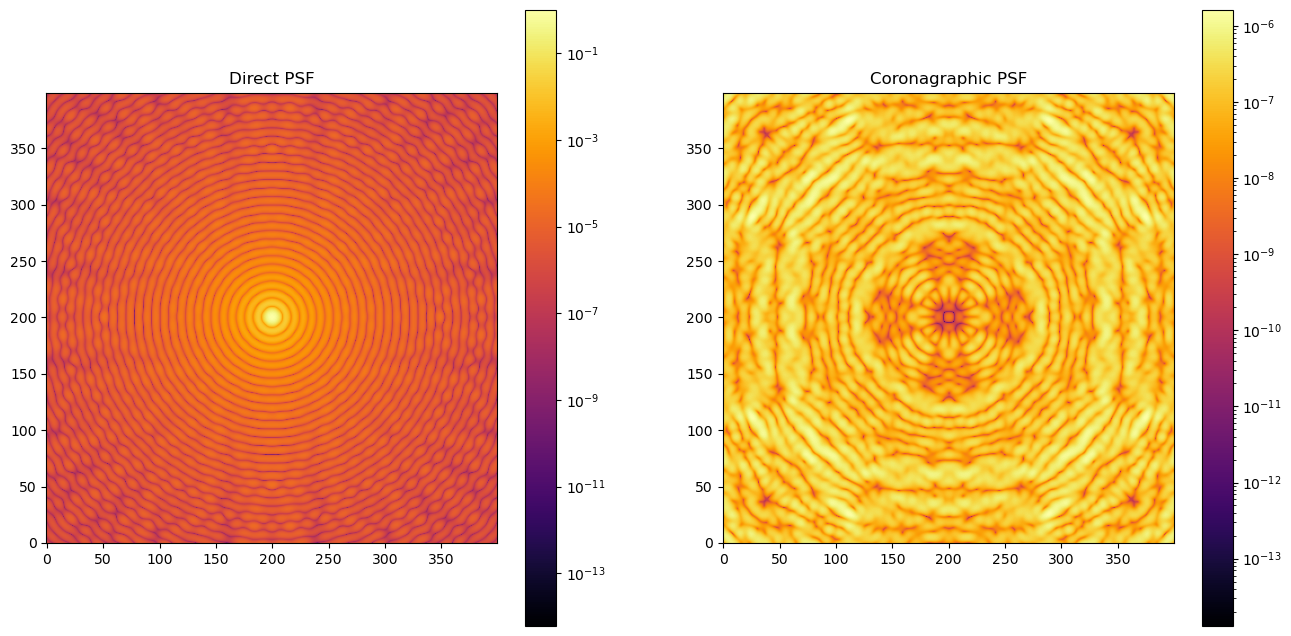

In [8]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(direct_psf/max_psf, cmap='inferno', norm=LogNorm(), origin='lower')
plt.title('Direct PSF')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(coro_psf/max_psf, cmap='inferno', norm=LogNorm(), origin='lower')
plt.title('Coronagraphic PSF')
plt.colorbar()

print(np.max(coro_psf/max_psf))

## Propagation through the full THD2 optical system

1.6564502736489654e-06


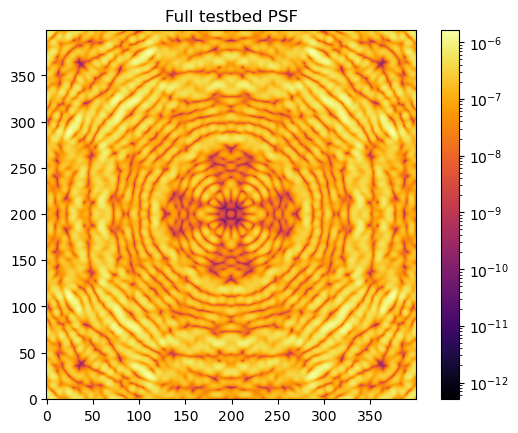

In [9]:
# Calculate the PSF through the whole optical system
direct_psf_after_testbed = thd2.todetector_intensity(noFPM=True)
norm_thd2 = direct_psf_after_testbed.max()
coro_psf_after_testbed = thd2.todetector_intensity()

plt.imshow(coro_psf_after_testbed/norm_thd2, cmap='inferno', origin='lower', norm=LogNorm())
plt.title('Full testbed PSF')
plt.colorbar()

print(np.max(coro_psf_after_testbed/norm_thd2))